<a href="https://colab.research.google.com/github/chiangsami/chiangsami/blob/main/Boltz1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is a work-in-progress notebook for [Boltz](https://github.com/jwohlwend/boltz)
# SAMI EDIT

⚠️ **Warning to Users:**
- **Alpha Version:** This notebook is currently under active development and is considered a beta version.
- **Usage at Your Own Risk:** Use this notebook at your own discretion and risk.

In [ ]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random
import requests
from string import ascii_uppercase

# Function to add a hash to the jobname
def add_hash(x, y):
    return x + "_" + hashlib.sha1(y.encode()).hexdigest()[:5]

# User inputs
query_sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASKK'  #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
ligand_input = 'N[C@@H](Cc1ccc(O)cc1)C(=O)O'  #@param {type:"string"}
#@markdown  - Use `:` to specify multiple ligands as smile strings
ligand_input_ccd = 'SAH'  #@param {type:"string"}
#@markdown - Use `:` to specify multiple ligands as CCD codes (three-letter codes)
ligand_input_common_name = ''  #@param {type:"string"}
#@markdown - Use `:` to specify multiple ligands with their common name (e.g. Aspirin; SMILES fetched from [PubChem](https://pubchem.ncbi.nlm.nih.gov) API)
dna_input = ''  #@param {type:"string"}
#@markdown - Use `:` to specify multiple DNA sequences
jobname = 'test'  #@param {type:"string"}

# Clean up the query sequence and jobname
query_sequence = "".join(query_sequence.split())
ligand_input = "".join(ligand_input.split())
ligand_input_ccd = "".join(ligand_input_ccd.split())
ligand_input_common_name = "".join(ligand_input_common_name.split())
dna_input = "".join(dna_input.split())
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# Check if a directory with jobname exists
def check(folder):
    return not os.path.exists(folder)

if not check(jobname):
    n = 0
    while not check(f"{jobname}_{n}"):
        n += 1
    jobname = f"{jobname}_{n}"

# Make directory to save results
os.makedirs(jobname, exist_ok=True)

from string import ascii_uppercase

# Split sequences on chain breaks
protein_sequences = query_sequence.strip().split(':') if query_sequence.strip() else []
ligand_sequences = ligand_input.strip().split(':') if ligand_input.strip() else []
ligand_sequences_ccd = ligand_input_ccd.strip().split(':') if ligand_input_ccd.strip() else []
ligand_sequences_common_name = ligand_input_common_name.strip().split(':') if ligand_input_common_name.strip() else []
dna_sequences = dna_input.strip().split(':') if dna_input.strip() else []

def get_smiles(compound_name):
    autocomplete_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/autocomplete/compound/{compound_name}/json?limit=1"
    autocomplete_response = requests.get(autocomplete_url)
    if autocomplete_response.status_code != 200:
        return None

    autocomplete_data = autocomplete_response.json()
    if autocomplete_data.get("status", {}).get("code") != 0 or autocomplete_data.get("total", 0) == 0:
        return None

    suggested_compound = autocomplete_data.get("dictionary_terms", {}).get("compound", [])
    if not suggested_compound:
        return None
    suggested_compound_name = suggested_compound[0]

    smiles_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{suggested_compound_name}/property/CanonicalSMILES/JSON"
    smiles_response = requests.get(smiles_url)
    if smiles_response.status_code != 200:
        return None

    smiles_data = smiles_response.json()
    properties = smiles_data.get("PropertyTable", {}).get("Properties", [])
    if len(properties) == 0:
        return None

    return properties[0].get("CanonicalSMILES")

smiles_cache = {}
for name in ligand_sequences_common_name:
    if name not in smiles_cache:
        smiles_cache[name] = get_smiles(name)
        if smiles_cache[name] is not None:
          print(f"Mapped compound {name} to {smiles_cache[name]}")

    if smiles_cache[name] is not None:
        ligand_sequences.append(smiles_cache[name])

# Initialize chain labels starting from 'A'
chain_labels = iter(ascii_uppercase)

fasta_entries = []
csv_entries = []
chain_label_to_seq_id = {}
seq_to_seq_id = {}
seq_id_counter = 0  # Counter for unique sequences

# Process protein sequences
for seq in protein_sequences:
    seq = seq.strip()
    if not seq:
        continue  # Skip empty sequences
    chain_label = next(chain_labels)
    # Check if sequence has been seen before
    if seq in seq_to_seq_id:
        seq_id = seq_to_seq_id[seq]
    else:
        seq_id = f"{jobname}_{seq_id_counter}"
        seq_to_seq_id[seq] = seq_id
        seq_id_counter += 1
        # For CSV file (for ColabFold), add only unique sequences
        csv_entries.append((seq_id, seq))
    chain_label_to_seq_id[chain_label] = seq_id
    # For FASTA file
    msa_path = os.path.join(jobname, f"{seq_id}.a3m")
    header = f">{chain_label}|protein|{msa_path}"
    sequence = seq
    fasta_entries.append((header, sequence))

# Process ligand sequences (assumed to be SMILES strings)
for lig in ligand_sequences:
    lig = lig.strip()
    if not lig:
        continue  # Skip empty ligands
    chain_label = next(chain_labels)
    lig_type = 'smiles'
    header = f">{chain_label}|{lig_type}"
    sequence = lig
    fasta_entries.append((header, sequence))

# Process DNA sequences (NO MSA is generated)
for seq in dna_sequences:
    seq = seq.strip()
    if not seq:
        continue  # Skip empty sequences
    chain_label = next(chain_labels)
    lig_type = 'DNA'
    header = f">{chain_label}|{lig_type}"
    sequence = seq
    fasta_entries.append((header, sequence))

# Process ligand sequences (CCD codes)
for lig in ligand_sequences_ccd:
    lig = lig.strip()
    if not lig:
        continue  # Skip empty ligands
    chain_label = next(chain_labels)
    lig_type = 'ccd'
    header = f">{chain_label}|{lig_type}"
    sequence = lig.upper()  # Ensure CCD codes are uppercase
    fasta_entries.append((header, sequence))

# Write the CSV file for ColabFold
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
    text_file.write("id,sequence\n")
    for seq_id, seq in csv_entries:
        text_file.write(f"{seq_id},{seq}\n")

# Write the FASTA file
queries_fasta = os.path.join(jobname, f"{jobname}.fasta")
with open(queries_fasta, 'w') as f:
    for header, sequence in fasta_entries:
        f.write(f"{header}\n{sequence}\n")

# Optionally, print the output for verification
#print(f"Generated FASTA file '{queries_fasta}':\n")
#for header, sequence in fasta_entries:
#    print(f"{header}\n{sequence}\n")


In [ ]:
#Upload YAML file
from google.colab import files
uploaded = files.upload()

Saving prot_ptp1b_test1.yaml to prot_ptp1b_test1.yaml


In [ ]:
mkdir -p /content/boltz/examples/

In [ ]:
import shutil


'/content/boltz/examples/prot_ptp1b_test1.yaml'

In [ ]:
!boltz predict /content/boltz/examples/prot_ptp1b_test1.yaml --accelerator gpu --use_msa_server

Checking input data.
Running predictions for 1 structure
Processing input data.
  0% 0/1 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/usr/local/bin/boltz", line 8, in <module>
    sys.exit(cli())
             ^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1157, in __call__
    return self.main(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1078, in main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1688, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1434, in invoke
    return ctx.invoke(self.callback, **ctx.params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 783, in inv

In [ ]:
ls

alphafold@  boltz_results_prot_ptp1b_test/  colabfold@       sample_data/
boltz/      BOLZ_READY                      COLABFOLD_READY  weights/


In [ ]:
import shutil
import os
from google.colab import files

# Define the results directory (adjust if needed)
results_dir = "/content/boltz_results_prot_ptp1b_test"

# Define the output zip file name
zip_filename = "boltz_results.zip"
zip_path = f"/content/{zip_filename}"

# Check if results directory exists
if os.path.exists(results_dir):
    # Zip the results directory
    shutil.make_archive(zip_path.replace(".zip", ""), 'zip', results_dir)
    print(f"✅ Results zipped to {zip_path}")

    # Download the zip file
    files.download(zip_path)
    print("📥 Download started...")
else:
    print("❌ No results found! Check if Boltz-1 ran successfully.")


  adding: content/boltz_results_prot_ptp1b_test/ (stored 0%)
  adding: content/boltz_results_prot_ptp1b_test/processed/ (stored 0%)
  adding: content/boltz_results_prot_ptp1b_test/processed/manifest.json (deflated 64%)
  adding: content/boltz_results_prot_ptp1b_test/processed/structures/ (stored 0%)
  adding: content/boltz_results_prot_ptp1b_test/processed/structures/prot_ptp1b_test.npz (deflated 4%)
  adding: content/boltz_results_prot_ptp1b_test/processed/msa/ (stored 0%)
  adding: content/boltz_results_prot_ptp1b_test/processed/msa/prot_ptp1b_test_0.npz (deflated 1%)
  adding: content/boltz_results_prot_ptp1b_test/processed/msa/prot_ptp1b_test_2.npz (deflated 34%)
  adding: content/boltz_results_prot_ptp1b_test/processed/msa/prot_ptp1b_test_1.npz (deflated 0%)
  adding: content/boltz_results_prot_ptp1b_test/predictions/ (stored 0%)
  adding: content/boltz_results_prot_ptp1b_test/predictions/prot_ptp1b_test/ (stored 0%)
  adding: content/boltz_results_prot_ptp1b_test/predictions/prot

In [ ]:
from google.colab import files
files.download("/content/ptp1b_results.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#check scores for boltz1

{
    "confidence_score": 0.44305095076560974,
    "ptm": 0.3326883316040039,
    "iptm": 0.16237889230251312,
    "ligand_iptm": 0.0,
    "protein_iptm": 0.16237889230251312,
    "complex_plddt": 0.5132189989089966,
    "complex_iplddt": 0.5302132964134216,
    "complex_pde": 3.69518780708313,
    "complex_ipde": 15.129851341247559,
    "chains_ptm": {
        "0": 0.6801642179489136,
        "1": 0.418257474899292,
        "2": 0.7745991349220276
    },
    "pair_chains_iptm": {
        "0": {
            "0": 0.6801642179489136,
            "1": 0.1651478260755539,
            "2": 0.09089960157871246
        },
        "1": {
            "0": 0.12052349746227264,
            "1": 0.418257474899292,
            "2": 0.17455682158470154
        },
        "2": {
            "0": 0.09331388771533966,
            "1": 0.48092302680015564,
            "2": 0.7745991349220276
        }
    }
}


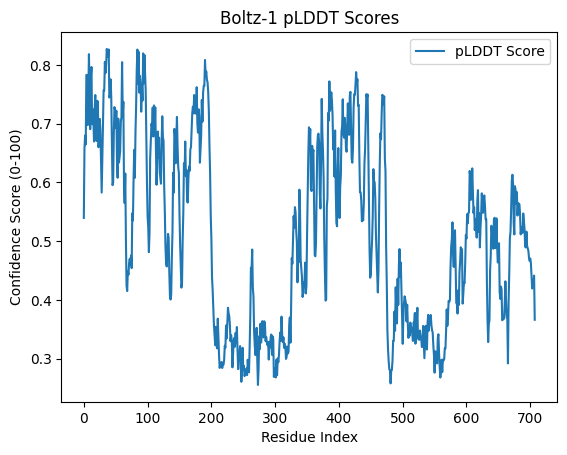

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

conf_path = "/content/boltz_results_prot_ptp1b_test/predictions/prot_ptp1b_test/confidence_prot_ptp1b_test_model_0.json"
try:
    with open(conf_path, "r") as f:
        conf_data = json.load(f)
    print(json.dumps(conf_data, indent=4))
except FileNotFoundError:
    print(f"❌ File not found: {conf_path}")

plddt_path = "/content/boltz_results_prot_ptp1b_test/predictions/prot_ptp1b_test/plddt_prot_ptp1b_test_model_0.npz"
try:
    plddt_data = np.load(plddt_path)["plddt"]
    plt.plot(plddt_data, label="pLDDT Score")
    plt.xlabel("Residue Index")
    plt.ylabel("Confidence Score (0-100)")
    plt.title("Boltz-1 pLDDT Scores")
    plt.legend()
    plt.show()
except FileNotFoundError:
    print(f"❌ File not found: {plddt_path}")


❌ No PAE file found in the directory.


In [ ]:
import zipfile
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Step 1: Upload ZIP file
print("📤 Upload your AlphaFold 3 results ZIP file")
uploaded = files.upload()

# Get the filename of the uploaded ZIP
zip_filename = list(uploaded.keys())[0]

# Step 2: Extract ZIP
output_dir = "/content/af3_results"
os.makedirs(output_dir, exist_ok=True)

with zipfile.ZipFile(zip_filename, "r") as zip_ref:
    zip_ref.extractall(output_dir)

print(f"✅ Extracted to: {output_dir}")

# Step 3: Locate confidence & PAE files
def find_file(directory, keyword):
    """Find a file in directory that contains a keyword."""
    for root, dirs, files in os.walk(directory):
        for file in files:
            if keyword in file:
                return os.path.join(root, file)
    return None

confidence_file = find_file(output_dir, "confidence")
pae_file = find_file(output_dir, "pae")
plddt_file = find_file(output_dir, "plddt")

# Step 4: Load Confidence Scores
if confidence_file:
    with open(confidence_file, "r") as f:
        confidence_data = json.load(f)
    print("\n🔹 AlphaFold 3 Confidence Scores:")
    print(json.dumps(confidence_data, indent=4))
else:
    print("❌ Confidence file not found.")

# Step 5: Load & Plot pLDDT
if plddt_file:
    plddt_data = np.load(plddt_file)["plddt"]

    plt.plot(plddt_data, label="pLDDT Score")
    plt.xlabel("Residue Index")
    plt.ylabel("Confidence Score (0-100)")
    plt.title("AlphaFold 3 pLDDT Scores")
    plt.legend()
    plt.show()
else:
    print("❌ pLDDT file not found.")

# Step 6: Load & Plot PAE
if pae_file:
    pae_data = np.load(pae_file)["pae"]

    plt.imshow(pae_data, cmap="coolwarm", interpolation="nearest")
    plt.colorbar(label="Predicted Alignment Error (Å)")
    plt.title("AlphaFold 3 PAE Matrix")
    plt.show()
else:
    print("❌ PAE file not found.")


📤 Upload your AlphaFold 3 results ZIP file


Saving fold_dipyetdpypyrk_src_ptp1b_1 (1).zip to fold_dipyetdpypyrk_src_ptp1b_1 (1).zip
✅ Extracted to: /content/af3_results

🔹 AlphaFold 3 Confidence Scores:
{
    "chain_iptm": [
        0.44,
        0.1,
        0.43
    ],
    "chain_pair_iptm": [
        [
            0.68,
            0.12,
            0.77
        ],
        [
            0.12,
            0.54,
            0.08
        ],
        [
            0.77,
            0.08,
            0.5
        ]
    ],
    "chain_pair_pae_min": [
        [
            0.76,
            26.51,
            2.46
        ],
        [
            27.89,
            0.76,
            29.76
        ],
        [
            2.69,
            27.12,
            0.76
        ]
    ],
    "chain_ptm": [
        0.68,
        0.54,
        0.5
    ],
    "fraction_disordered": 0.24,
    "has_clash": 0.0,
    "iptm": 0.3,
    "num_recycles": 10.0,
    "ptm": 0.4,
    "ranking_score": 0.44
}
❌ pLDDT file not found.
❌ PAE file not found.


In [ ]:
#@title Generate MSA with ColabFold
!colabfold_batch "{queries_path}" "{jobname}" --msa-only

In [ ]:
#@title Predict structure using boltz
!boltz predict --out_dir "{jobname}" "{jobname}/{jobname}.fasta" --cache weights

In [ ]:
#@title Download results
# Import necessary modules
import os
import zipfile
from google.colab import files
import glob

# Ensure 'jobname' variable is defined
# jobname = 'test_abcde'  # Uncomment and set if not already defined

# Name of the zip file
zip_filename = f"results_{jobname}.zip"

# Create a zip file and add the specified files without preserving directory structure
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    coverage_png_files = glob.glob(os.path.join(jobname, '*_coverage.png'))
    a3m_files = glob.glob(os.path.join(jobname, '*.a3m'))
    for file in coverage_png_files + a3m_files:
        arcname = os.path.basename(file)  # Use only the file name
        zipf.write(file, arcname=arcname)

    cif_files = glob.glob(os.path.join(jobname, f'boltz_results_{jobname}', 'predictions', jobname, '*.cif'))
    for file in cif_files:
        arcname = os.path.basename(file)  # Use only the file name
        zipf.write(file, arcname=arcname)

    hparams_file = os.path.join(jobname, f'boltz_results_{jobname}', 'lightning_logs', 'version_0', 'hparams.yaml')
    if os.path.exists(hparams_file):
        arcname = os.path.basename(hparams_file)  # Use only the file name
        zipf.write(hparams_file, arcname=arcname)
    else:
        print(f"Warning: {hparams_file} not found.")

# Download the zip file
files.download(zip_filename)


AUTOMATED VERSION STARTS HERE:

In [ ]:
#Cleaned up code:

In [1]:
#@title Install dependencies
%%time
import os
if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if not os.path.isfile("BOLZ_READY"):
  os.system("apt-get install -y aria2")
  os.system("pip install -q --no-warn-conflicts boltz")
  os.system("mkdir weights")
  os.system("aria2c -d weights -x8 -s8 https://colabfold.steineggerlab.workers.dev/boltz1.ckpt")
  os.system("aria2c -d weights -x8 -s8 https://colabfold.steineggerlab.workers.dev/ccd.pkl")
  os.system("touch BOLZ_READY")

installing colabfold...
CPU times: user 805 ms, sys: 142 ms, total: 947 ms
Wall time: 4min 46s


This uploads the YAML, moves it to the "examples" folder, and runs Boltz-1 automatically.

In [11]:
import shutil
import os
from google.colab import files

# Create examples directory
os.makedirs("/content/boltz/examples/", exist_ok=True)

# Upload YAML file
uploaded = files.upload()
filename = list(uploaded.keys())[0]
dest_path = f"/content/boltz/examples/{filename}"

# Move file to the examples folder
shutil.move(filename, dest_path)
print(f"Moved {filename} to {dest_path}")

# Run Boltz-1 prediction
!boltz predict {dest_path} --accelerator gpu --use_msa_server

Saving prot_ptp1b_test2.yaml to prot_ptp1b_test2.yaml
Moved prot_ptp1b_test2.yaml to /content/boltz/examples/prot_ptp1b_test2.yaml
Checking input data.
Running predictions for 1 structure
Processing input data.
Found a manifest file at output directory: boltz_results_prot_ptp1b_test2
All examples in data are processed. Updating the manifest
Traceback (most recent call last):
  File "/usr/local/bin/boltz", line 8, in <module>
    sys.exit(cli())
             ^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1157, in __call__
    return self.main(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1078, in main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1688, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3

Download to ZIP

In [ ]:
import shutil
import os
from google.colab import files

# Define results directory and zip file name
results_dir = "/content/boltz_results"
zip_filename = "boltz_results.zip"
zip_path = f"/content/{zip_filename}"

# Check if results directory exists
if os.path.exists(results_dir):
    shutil.make_archive(zip_path.replace(".zip", ""), 'zip', results_dir)
    print(f"Results zipped to {zip_path}")

    # Download the zip file
    files.download(zip_path)
    print("Download started...")
else:
    print("No results found, Check if Boltz-1 ran successfully.")


Choose which result you are analyzing

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os

# Define results directory
results_path = "/content/boltz_results"

# List available prediction folders
prediction_dirs = [d for d in os.listdir(results_path) if os.path.isdir(os.path.join(results_path, d))]

if not prediction_dirs:
    print(" No prediction results found. Please run Boltz-1 first.")
else:
    print(" Available Predictions:")
    for i, pred_dir in enumerate(prediction_dirs):
        print(f"{i + 1}. {pred_dir}")

    # Let the user choose a prediction
    choice = input("\nEnter the number of the prediction you want to analyze: ")

    try:
        choice_index = int(choice) - 1
        if choice_index < 0 or choice_index >= len(prediction_dirs):
            raise ValueError("Invalid selection.")

        selected_pred = prediction_dirs[choice_index]
        confidence_file = f"{results_path}/{selected_pred}/predictions/{selected_pred}/confidence_{selected_pred}_model_0.json"

        with open(confidence_file, "r") as f:
            data = json.load(f)
            print(f"\n Confidence Scores for {selected_pred}:")
            print(json.dumps(data, indent=4))

        # Load and plot pLDDT scores
        plddt_file = f"{results_path}/{selected_pred}/predictions/{selected_pred}/plddt_{selected_pred}_model_0.npz"
        plddt = np.load(plddt_file)["plddt"]

        plt.figure(figsize=(10, 5))
        plt.plot(plddt, label=f"pLDDT Scores - {selected_pred}", color="blue")
        plt.xlabel("Residue Index")
        plt.ylabel("pLDDT Score")
        plt.title(f"Boltz-1 pLDDT Score for {selected_pred}")
        plt.legend()
        plt.show()

    except (ValueError, FileNotFoundError) as e:
        print(f"Error: {e}. Please check the available predictions")


AF3 comparison

In [ ]:
import zipfile

# Upload multiple AF3 zip files
uploaded_af3 = files.upload()

for af3_zip in uploaded_af3.keys():
    af3_extract_path = f"/content/{af3_zip.replace('.zip', '')}"
    os.makedirs(af3_extract_path, exist_ok=True)

    with zipfile.ZipFile(af3_zip, 'r') as zip_ref:
        zip_ref.extractall(af3_extract_path)

    print(f" Extracted AlphaFold 3 results to {af3_extract_path}")

    # Load AF3 confidence scores
    af3_confidence_file = f"{af3_extract_path}/confidence.json"

    try:
        with open(af3_confidence_file, "r") as f:
            af3_data = json.load(f)
            print(f" Confidence Scores for {af3_zip}:")
            print(json.dumps(af3_data, indent=4))

        # Load and plot AF3 pLDDT
        af3_plddt_file = f"{af3_extract_path}/plddt.npz"
        af3_plddt = np.load(af3_plddt_file)["plddt"]

        plt.figure(figsize=(10, 5))
        plt.plot(af3_plddt, label=f"AF3 pLDDT Scores - {af3_zip}", color="green")
        plt.xlabel("Residue Index")
        plt.ylabel("pLDDT Score")
        plt.title(f"AlphaFold 3 pLDDT Score for {af3_zip}")
        plt.legend()
        plt.show()
    except FileNotFoundError:
        print(f" AlphaFold 3 confidence scores not found for {af3_zip}. Check if the zip file is correct.")


Compare AF3 Vs Boltz-1

In [ ]:
import pandas as pd

# Loop through each predicted structure
for pred_dir in prediction_dirs:
    try:
        # Load Boltz-1 data
        confidence_file = f"{results_path}/{pred_dir}/predictions/{pred_dir}/confidence_{pred_dir}_model_0.json"
        with open(confidence_file, "r") as f:
            boltz_data = json.load(f)

        boltz_ptm = boltz_data["ptm"]
        boltz_iptm = boltz_data["iptm"]
        boltz_plddt_file = f"{results_path}/{pred_dir}/predictions/{pred_dir}/plddt_{pred_dir}_model_0.npz"
        boltz_plddt = np.load(boltz_plddt_file)["plddt"]

        # Find matching AF3 result
        af3_extract_path = f"/content/{pred_dir}_af3"
        af3_confidence_file = f"{af3_extract_path}/confidence.json"
        with open(af3_confidence_file, "r") as f:
            af3_data = json.load(f)

        af3_ptm = af3_data["ptm"]
        af3_iptm = af3_data["iptm"]
        af3_plddt_file = f"{af3_extract_path}/plddt.npz"
        af3_plddt = np.load(af3_plddt_file)["plddt"]

        # Create a comparison dataframe
        comparison_df = pd.DataFrame({
            "Residue Index": list(range(len(boltz_plddt))),
            "Boltz-1 pLDDT": boltz_plddt,
            "AF3 pLDDT": af3_plddt[:len(boltz_plddt)]
        })

        # Print summary stats
        print(f"Comparison for {pred_dir}:")
        print(f"Boltz-1 PTM: {boltz_ptm}, iPTM: {boltz_iptm}")
        print(f"AF3 PTM: {af3_ptm}, iPTM: {af3_iptm}")

        # Plot pLDDT Comparison
        plt.figure(figsize=(10, 5))
        plt.plot(comparison_df["Residue Index"], comparison_df["Boltz-1 pLDDT"], label="Boltz-1", color="blue")
        plt.plot(comparison_df["Residue Index"], comparison_df["AF3 pLDDT"], label="AlphaFold 3", color="green")
        plt.xlabel("Residue Index")
        plt.ylabel("pLDDT Score")
        plt.title(f"Boltz-1 vs AlphaFold 3: pLDDT Scores for {pred_dir}")
        plt.legend()
        plt.show()
    except FileNotFoundError:
        print(f" Could not compare {pred_dir}. Missing files.")
